# Problem Set 2: Risk Measures

## Task 1: Estimation, Interpretation

### a)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from dateutil.relativedelta import relativedelta

In [2]:
confidence_level = 0.95

In [3]:
data = pd.read_csv(r'PS2 - Data.csv', index_col = 0)
data.set_index('date', drop = True, inplace = True)
print(data.head(n = 5))

            JP_MORGAN_CHASE  EXXON_MOBIL     INTEL    PFIZER    BOEING  \
date                                                                     
1973-01-03        -0.002300     0.012800 -0.009900  0.002900  0.023900   
1973-01-04         0.000000     0.002765 -0.009999  0.011367 -0.009278   
1973-01-05        -0.002406     0.005612  0.000000  0.005718 -0.018927   
1973-01-08         0.002411     0.004210  0.010100 -0.022547  0.014469   
1973-01-09        -0.007016     0.000000  0.029997  0.000000 -0.014263   

                 RF  
date                 
1973-01-03  0.00021  
1973-01-04  0.00021  
1973-01-05  0.00021  
1973-01-08  0.00021  
1973-01-09  0.00021  


In [4]:
weights = [1/5, 1/5, 1/5, 1/5, 1/5]

dates = np.array(data.index)
stocks = np.array(data.columns[0:5])

portfolio = pd.DataFrame()
for date in dates:
    portfolio_return = 0
    for stock, weight in zip(stocks, weights):
        portfolio_return += data.loc[date, stock] * weight
    portfolio.loc[date, 'PORTFOLIO RETURN'] = portfolio_return
print(portfolio)

            PORTFOLIO RETURN
1973-01-03          0.005480
1973-01-04         -0.001029
1973-01-05         -0.002000
1973-01-08          0.001729
1973-01-09          0.001744
...                      ...
2021-07-20          0.022429
2021-07-21          0.019044
2021-07-22         -0.005043
2021-07-23         -0.009607
2021-07-26          0.015867

[12248 rows x 1 columns]


In [5]:
assets = np.concatenate([['PORTFOLIO'], stocks])
measures = np.array(['Mean Absolute Deviation', 'Semi Std', 'Empirical VaR', 'Empirical ES'])

data_agg = pd.concat([portfolio, data], axis = 1)
data_agg.drop('RF', axis = 1, inplace = True)
risk_measures = pd.DataFrame(index = measures, columns = assets)

periods = len(data_agg.index)
dates = np.array(data_agg.index)
assets = np.array(data_agg.columns)

# Quantile Generation Check
normal_dist = pd.Series(np.random.normal(loc = 0.0, scale = 1.0, size = 100000))
return_quantile_normal = normal_dist.quantile(q = 1-confidence_level)
print(f'\nQuantile Check of N(0,1): {round(return_quantile_normal, 2)}\n')

for asset in assets:
    return_mean = data_agg[asset].mean()
    return_variance = data_agg[asset].var()
    return_quantile = data_agg[asset].quantile(q = 1-confidence_level)
    absolute_deviation = 0
    semi_variance = 0
    for date in dates:
        if data_agg.loc[date, asset] <= return_mean:
            delta = 1
        else:
            delta = 0
        absolute_deviation += np.absolute(data_agg.loc[date, asset] - return_mean)
        semi_variance += delta * ((data_agg.loc[date, asset] - return_mean)**2)
    mean_absolute_deviation = absolute_deviation / periods
    semi_variance = semi_variance / periods
    semi_std = np.sqrt(semi_variance)
    # empirical_var = -(return_mean + (return_quantile * np.sqrt(return_variance)))
    empirical_var = -return_quantile
    deltas = 0
    empirical_es = 0
    for date in dates:
        if data_agg.loc[date, asset] <= -empirical_var:
            delta = 1
        else:
            delta = 0
        deltas += delta
        empirical_es += delta * data_agg.loc[date, asset]
    empirical_es = (-1/deltas) * empirical_es
    risk_measures.loc['Mean Absolute Deviation', asset] = round(mean_absolute_deviation, 5)
    risk_measures.loc['Semi Std', asset] = round(semi_std, 5)
    risk_measures.loc['Empirical VaR', asset] = round(empirical_var, 5)
    risk_measures.loc['Empirical ES', asset] = round(empirical_es, 5)
    
print(risk_measures)


Quantile Check of N(0,1): -1.65

                        PORTFOLIO JP_MORGAN_CHASE EXXON_MOBIL    INTEL  \
Mean Absolute Deviation       NaN         0.01435     0.01052  0.01865   
Semi Std                      NaN         0.01486     0.01054  0.01889   
Empirical VaR                 NaN         0.03047     0.02191  0.03847   
Empirical ES                  NaN         0.04741     0.03286  0.05986   

                          PFIZER   BOEING  PORTFOLIO RETURN  
Mean Absolute Deviation  0.01239  0.01455           0.00979  
Semi Std                 0.01204  0.01451           0.00993  
Empirical VaR            0.02559   0.0299           0.02051  
Empirical ES             0.03801  0.04564           0.03094  


### b)

seen in the solution sheet

### c)

In [6]:
dates = np.array(portfolio.index)

portfolio_value = 100
monthly_portfolio = pd.DataFrame(index = dates, columns = ['PORTFOLIO VALUE'])
for date in dates:
    daily_return = portfolio.loc[date, 'PORTFOLIO RETURN']
    portfolio_value = portfolio_value * (1 + daily_return)
    monthly_portfolio.loc[date, 'PORTFOLIO VALUE'] = portfolio_value

monthly_portfolio['MONTHLY PORTFOLIO RETURN'] = monthly_portfolio['PORTFOLIO VALUE'].pct_change(periods = 21)
monthly_portfolio.drop('PORTFOLIO VALUE', axis = 1, inplace = True)
monthly_portfolio.dropna(axis = 0, inplace = True)
    
print(monthly_portfolio)

            MONTHLY PORTFOLIO RETURN
1973-02-02                 -0.056548
1973-02-05                 -0.063560
1973-02-06                 -0.072307
1973-02-07                 -0.084580
1973-02-08                 -0.082514
...                              ...
2021-07-20                 -0.018334
2021-07-21                 -0.020397
2021-07-22                 -0.028526
2021-07-23                 -0.035449
2021-07-26                 -0.031808

[12227 rows x 1 columns]


In [7]:
monthly_measures = pd.DataFrame(index = ['Empirical VaR', 'Theoretical VaR', 'Empirical ES', 'Theoretical ES'], columns = ['MONTHLY PORTFOLIO RETURN'])
dates = np.array(monthly_portfolio.index)

normal_dist = pd.Series(np.random.normal(loc = 0.0, scale = 1.0, size = 100000))
return_quantile_normal = normal_dist.quantile(q = 1-confidence_level)

monthly_return_mean = monthly_portfolio['MONTHLY PORTFOLIO RETURN'].mean()
monthly_return_variance = monthly_portfolio['MONTHLY PORTFOLIO RETURN'].var()
monthly_return_quantile = monthly_portfolio['MONTHLY PORTFOLIO RETURN'].quantile(q = 1-confidence_level)

empirical_var = -return_quantile
theoretical_var = -(monthly_return_mean + (return_quantile_normal * np.sqrt(monthly_return_variance)))

empirical_es = 0
for date in dates:
    if monthly_portfolio.loc[date, 'MONTHLY PORTFOLIO RETURN'] <= -empirical_var:
        delta = 1
    else:
        delta = 0
    deltas += delta
    empirical_es += delta * monthly_portfolio.loc[date, 'MONTHLY PORTFOLIO RETURN']
empirical_es = (-1/deltas) * empirical_es

theoretical_es = 0
for date in dates:
    if monthly_portfolio.loc[date, 'MONTHLY PORTFOLIO RETURN'] <= -theoretical_var:
        delta = 1
    else:
        delta = 0
    deltas += delta
    theoretical_es += delta * monthly_portfolio.loc[date, 'MONTHLY PORTFOLIO RETURN']
theoretical_es = (-1/deltas) * theoretical_es

monthly_measures.loc['Empirical VaR', 'MONTHLY PORTFOLIO RETURN'] = round(empirical_var, 5)
monthly_measures.loc['Theoretical VaR', 'MONTHLY PORTFOLIO RETURN'] = round(theoretical_var, 5)
monthly_measures.loc['Empirical ES', 'MONTHLY PORTFOLIO RETURN'] = round(empirical_es, 5)
monthly_measures.loc['Theoretical ES', 'MONTHLY PORTFOLIO RETURN'] = round(theoretical_es, 5)
    
print(monthly_measures)

                MONTHLY PORTFOLIO RETURN
Empirical VaR                     0.0299
Theoretical VaR                  0.08258
Empirical ES                      0.0545
Theoretical ES                    0.0206


### d)

In [8]:
dates = [dt.datetime.strptime(i, '%Y-%m-%d').date() for i in np.array(monthly_portfolio.index)]
monthly_portfolio.index = [dt.datetime.strptime(j, '%Y-%m-%d').date() for j in np.array(monthly_portfolio.index)]
portfolio.index = [dt.datetime.strptime(k, '%Y-%m-%d').date() for k in np.array(portfolio.index)]

In [9]:
log_prices = np.log(monthly_portfolio['MONTHLY PORTFOLIO RETURN'] + 1)
plot_data = pd.DataFrame(index = np.array(monthly_portfolio.index), columns = ['LOG PRICES', 'SEMI STD'])

first_date = dates[0] + relativedelta(years = 5)
for date in dates:
    if date < first_date:
        plot_data.loc[date, 'LOG PRICES'] = np.nan
        plot_data.loc[date, 'SEMI STD'] = np.nan
    else:
        end_date = date
        start_date = end_date - relativedelta(years = 5)
        after_start_date = monthly_portfolio.index >= start_date
        before_end_date = monthly_portfolio.index <= end_date
        between_start_end_date = after_start_date & before_end_date
        rolling_monthly_portfolio = monthly_portfolio.loc[between_start_end_date]

        rolling_dates = np.array(rolling_monthly_portfolio.index)
        return_mean = rolling_monthly_portfolio['MONTHLY PORTFOLIO RETURN'].mean()
        periods = len(np.array(rolling_monthly_portfolio.index))
        
        price = 100
        semi_variance = 0
        for rolling_date in rolling_dates:
            price = price * (1 + portfolio.loc[rolling_date, ['PORTFOLIO RETURN']][0])
            if rolling_monthly_portfolio.loc[rolling_date, ['MONTHLY PORTFOLIO RETURN']][0] <= return_mean:
                delta = 1
            else:
                delta = 0
            semi_variance += delta * ((rolling_monthly_portfolio.loc[rolling_date, ['MONTHLY PORTFOLIO RETURN']][0] - return_mean)**2)
        semi_variance = semi_variance / periods
        semi_std = np.sqrt(semi_variance)
        plot_data.loc[date, 'LOG PRICES'] = np.log(price) - np.log(100)
        plot_data.loc[date, 'SEMI STD'] = semi_std

print(plot_data)

           LOG PRICES  SEMI STD
1973-02-02        NaN       NaN
1973-02-05        NaN       NaN
1973-02-06        NaN       NaN
1973-02-07        NaN       NaN
1973-02-08        NaN       NaN
...               ...       ...
2021-07-20   0.566714  0.051648
2021-07-21   0.583126  0.051634
2021-07-22   0.588607  0.051627
2021-07-23   0.575171  0.051619
2021-07-26   0.595709  0.051617

[12227 rows x 2 columns]


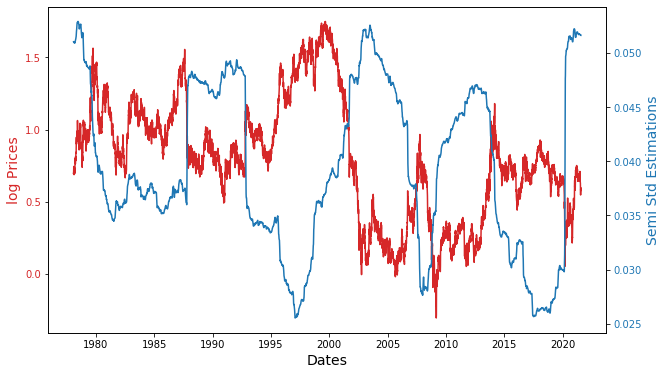

In [28]:
x = plot_data.index
y_1 = plot_data['LOG PRICES'].to_numpy()
y_2 = plot_data['SEMI STD'].to_numpy()

fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)

color = 'tab:red'
ax1.set_xlabel('Dates', size = 14)
ax1.set_ylabel('log Prices', color = color, size = 14)
ax1.plot(x, y_1, color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Semi Std Estimations', color = color, size = 14) 
ax2.plot(x, y_2, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.show()

### e)

In [26]:
# Use variable "monthly_portfolio" as the rolling monthly portfolio return series for any computations in e) - h)